In [1]:
import pandas as pd

## 파일 불러오기 

In [2]:
df = pd.read_csv('../final/df_final.csv')

In [3]:
pd.set_option('display.max_columns', None) # 컬럼 전체 보기

In [4]:
# 북부 지역
df_north = df[df['customer_state'].isin(['AC', 'AM', 'RO', 'RR', 'PA', 'AP','TO'])]

# 중서부 지역
df_central = df[df['customer_state'].isin(['MT', 'MS', 'GO','DF'])]

# 북동부 지역
df_northeast = df[df['customer_state'].isin(['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'])]

# 남동부 지역
df_southeast = df[df['customer_state'].isin(['SP', 'RJ', 'MG', 'ES'])]

# 남부 지역
df_south = df[df['customer_state'].isin(['PR', 'SC', 'RS'])] 

# 브라질 행정 구역 기반으로 5가지 지역 분리


## 각 지역마다 상위 상품 시각화

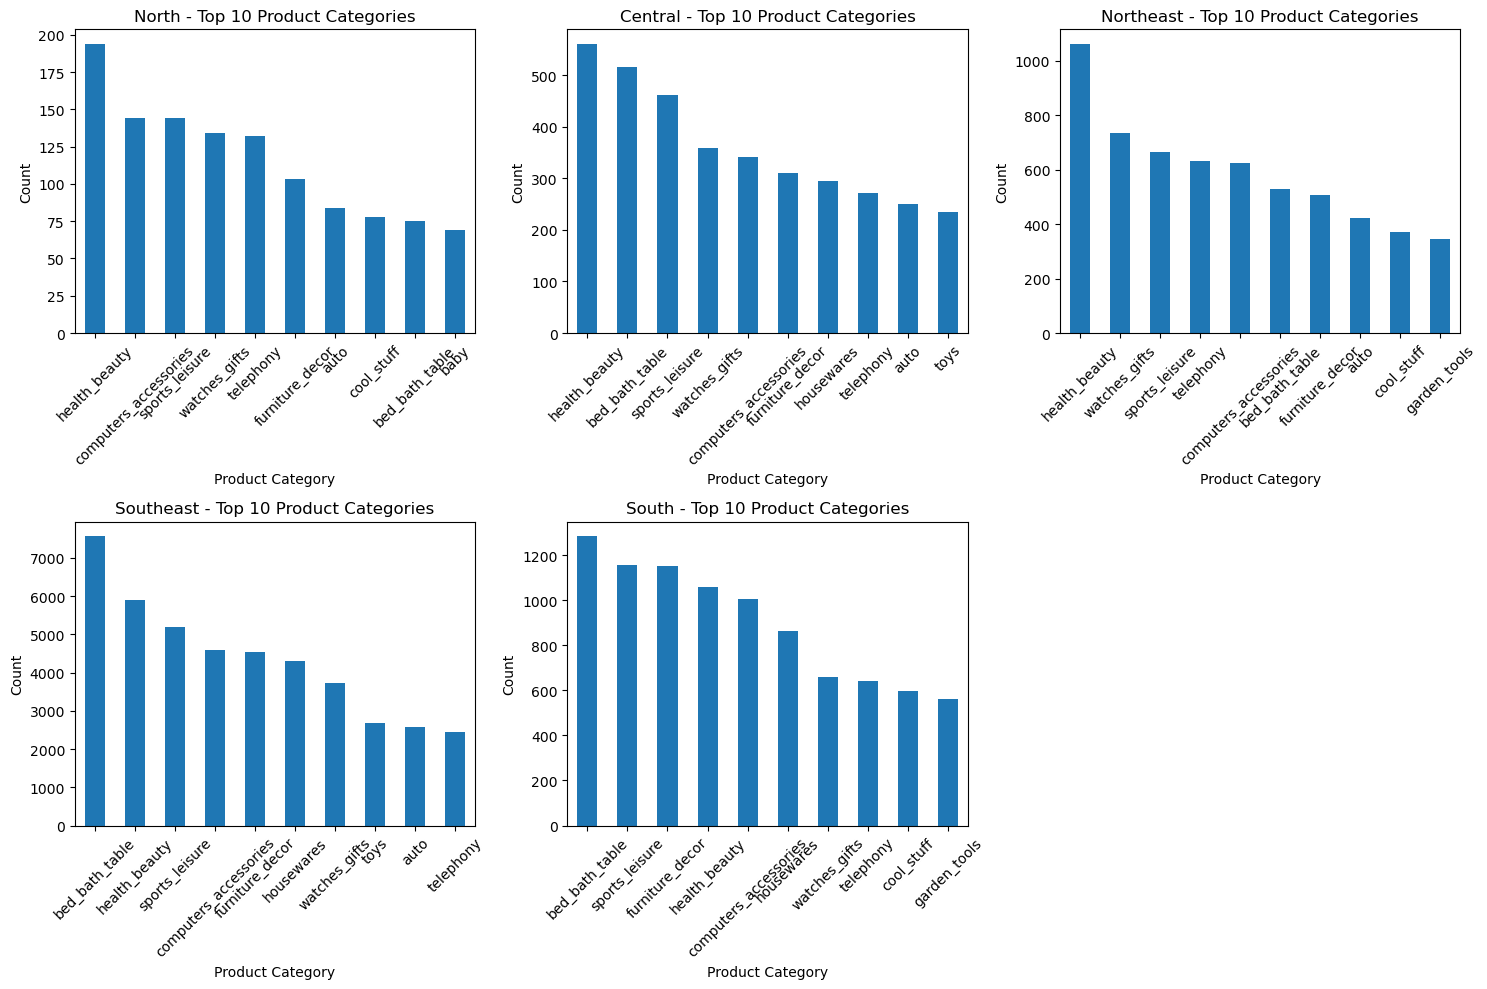

In [5]:
import matplotlib.pyplot as plt

# 지역별 상위 10개 데이터
top_categories = {}

# 각 지역에 대해 상위 10개 데이터 추출
regions = ['north', 'central', 'northeast', 'southeast', 'south']
for region in regions:
    # 해당 지역의 데이터프레임
    df_region = globals()[f"df_{region}"]
    
    # 'product_category_name' 컬럼 값들의 밸류 카운트
    category_counts = df_region['product_category_name'].value_counts()
    
    # 상위 10개 데이터 추출
    top_categories[region] = category_counts[:10]

plt.figure(figsize=(15, 10))

# 각 지역의 상위 10개 데이터를 하나씩 subplot으로 그리기
for i, region in enumerate(regions):
    plt.subplot(2, 3, i+1)
    top_categories[region].plot(kind='bar')
    plt.title(f'{region.capitalize()} - Top 10 Product Categories')
    plt.xlabel('Product Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 북부 지역

In [6]:
df_north = df_north.reset_index(drop=True)

In [7]:
import folium
from sklearn.cluster import KMeans
import numpy as np

def kmeans_clustering_and_map(location_data, n_clusters=3):
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
    
    # 클러스터의 중심점 확인
    hub_locations = kmeans.cluster_centers_
    
    # 지도 생성을 위한 중심점 계산
    map_center = np.mean(hub_locations, axis=0)
    
    # 클러스터 중심점 간 최대 거리 계산
    max_distance = np.max([np.linalg.norm(i-j) for i in hub_locations for j in hub_locations])

    # zoom_start 
    if max_distance < 0.02:
        zoom_start = 12
    elif max_distance < 0.05:
        zoom_start = 10
    elif max_distance < 0.1:
        zoom_start = 8
    else:
        zoom_start = 6
    
    # 지도 생성
    map = folium.Map(location=map_center.tolist(), zoom_start=zoom_start)

    # 중심 허브 위치에 마커 추가
    for idx, (lat, lng) in enumerate(hub_locations):
        folium.Marker(
            [lat, lng], 
            icon=folium.Icon(color='blue'), 
            popup=f'Hub {idx+1}'
        ).add_to(map)

    return map, hub_locations

location_data = df_north[['customer_lat', 'customer_lng']].values
map, hub_locations = kmeans_clustering_and_map(location_data)
print(hub_locations)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ -1.67663444 -49.09748108]
 [ -7.0756575  -62.64570074]
 [ -9.13582975 -48.90111266]]


## 북부지역 상위 카테고리 5개 K-means

In [12]:
df_north_hb = df_north[df_north['product_category_name'].isin(['health_beauty'])]
df_north_ca = df_north[df_north['product_category_name'].isin(['computers_accessories'])]
df_north_sl = df_north[df_north['product_category_name'].isin(['sports_leisure'])]
df_north_tel = df_north[df_north['product_category_name'].isin(['telephony'])]
df_north_wg = df_north[df_north['product_category_name'].isin(['watches_gifts'])]

In [13]:
def kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names):
    # 모든 데이터프레임의 위치 데이터를 합쳐 지도의 중심점을 계산
    all_locations = np.vstack([df[['customer_lat', 'customer_lng']].values for df in dataframes])
    map_center = np.mean(all_locations, axis=0)
    map = folium.Map(location=map_center.tolist(), zoom_start=6)  

    # 각 데이터프레임에 대해 클러스터링 수행
    for df, n_clusters, color, name in zip(dataframes, n_clusters_list, colors, names):
        location_data = df[['customer_lat', 'customer_lng']].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
        hub_locations = kmeans.cluster_centers_

        # 클러스터 중심점에 색상별 마커 추가
        for idx, (lat, lng) in enumerate(hub_locations):
            popup_text = f'{name} Cluster {idx+1}: ({lat:.5f}, {lng:.5f})'
            folium.Marker(
                [lat, lng], 
                icon=folium.Icon(color=color), 
                popup=popup_text
            ).add_to(map)

    return map

dataframes = [df_north_hb, df_north_ca, df_north_sl, df_north_tel, df_north_wg]
n_clusters_list = [3, 3, 3, 3, 3]  # 모든 데이터프레임에 대해 3개의 클러스터 사용
colors = ['red', 'blue', 'green', 'purple', 'orange']  # 마커 색상
names = ['HB', 'CA', 'SL', 'Tel', 'Wg']  # 데이터프레임 이름

map = kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

## 중서부 지역

In [14]:
df_central = df_central.reset_index(drop=True)

In [15]:
def kmeans_clustering_and_map(location_data, n_clusters=3):
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
    
    # 클러스터의 중심점 확인
    hub_locations = kmeans.cluster_centers_
    
    # 지도 생성을 위한 중심점 계산
    map_center = np.mean(hub_locations, axis=0)
    
    # 클러스터 중심점 간 최대 거리 계산
    max_distance = np.max([np.linalg.norm(i-j) for i in hub_locations for j in hub_locations])

    # zoom_start 
    if max_distance < 0.02:
        zoom_start = 12
    elif max_distance < 0.05:
        zoom_start = 10
    elif max_distance < 0.1:
        zoom_start = 8
    else:
        zoom_start = 6
    
    # 지도 생성
    map = folium.Map(location=map_center.tolist(), zoom_start=zoom_start)

    # 중심 허브 위치에 마커 추가
    for idx, (lat, lng) in enumerate(hub_locations):
        folium.Marker(
            [lat, lng], 
            icon=folium.Icon(color='blue'), 
            popup=f'Hub {idx+1}'
        ).add_to(map)

    return map, hub_locations

location_data = df_central[['customer_lat', 'customer_lng']].values
map, hub_locations = kmeans_clustering_and_map(location_data)
print(hub_locations)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-14.32915658 -55.96807731]
 [-16.14835125 -48.57560662]
 [-20.32161047 -54.09419375]]


## 중서부지역 상위 카테고리 5개 K-means

In [16]:
df_central_hb = df_central[df_central['product_category_name'].isin(['health_beauty'])]
df_central_bed = df_central[df_central['product_category_name'].isin(['bed_bath_table'])]
df_central_sl = df_central[df_central['product_category_name'].isin(['sports_leisure'])]
df_central_wg = df_central[df_central['product_category_name'].isin(['watches_gifts'])]
df_central_ca = df_central[df_central['product_category_name'].isin(['computers_accessories'])]

In [17]:
def kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names):
    # 모든 데이터프레임의 위치 데이터를 합쳐 지도의 중심점을 계산
    all_locations = np.vstack([df[['customer_lat', 'customer_lng']].values for df in dataframes])
    map_center = np.mean(all_locations, axis=0)
    map = folium.Map(location=map_center.tolist(), zoom_start=6)  

    # 각 데이터프레임에 대해 클러스터링 수행
    for df, n_clusters, color, name in zip(dataframes, n_clusters_list, colors, names):
        location_data = df[['customer_lat', 'customer_lng']].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
        hub_locations = kmeans.cluster_centers_

        # 클러스터 중심점에 색상별 마커 추가
        for idx, (lat, lng) in enumerate(hub_locations):
            popup_text = f'{name} Cluster {idx+1}: ({lat:.5f}, {lng:.5f})'
            folium.Marker(
                [lat, lng], 
                icon=folium.Icon(color=color), 
                popup=popup_text
            ).add_to(map)

    return map

dataframes = [df_central_hb, df_central_bed, df_central_sl, df_central_wg, df_central_ca]
n_clusters_list = [3, 3, 3, 3, 3]  # 모든 데이터프레임에 대해 3개의 클러스터 사용
colors = ['red', 'blue', 'green', 'purple', 'orange']  # 마커 색상
names = ['HB', 'Bed', 'SL', 'Wg', 'Ca']  # 데이터프레임 이름

map = kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

## 북동부 지역

In [18]:
df_northeast = df_northeast.reset_index(drop=True)

In [19]:
def kmeans_clustering_and_map(location_data, n_clusters=3):
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
    
    # 클러스터의 중심점 확인
    hub_locations = kmeans.cluster_centers_
    
    # 지도 생성을 위한 중심점 계산
    map_center = np.mean(hub_locations, axis=0)
    
    # 클러스터 중심점 간 최대 거리 계산
    max_distance = np.max([np.linalg.norm(i-j) for i in hub_locations for j in hub_locations])

    # zoom_start 
    if max_distance < 0.02:
        zoom_start = 12
    elif max_distance < 0.05:
        zoom_start = 10
    elif max_distance < 0.1:
        zoom_start = 8
    else:
        zoom_start = 6
    
    # 지도 생성
    map = folium.Map(location=map_center.tolist(), zoom_start=zoom_start)

    # 중심 허브 위치에 마커 추가
    for idx, (lat, lng) in enumerate(hub_locations):
        folium.Marker(
            [lat, lng], 
            icon=folium.Icon(color='blue'), 
            popup=f'Hub {idx+1}'
        ).add_to(map)

    return map, hub_locations

location_data = df_northeast[['customer_lat', 'customer_lng']].values
map, hub_locations = kmeans_clustering_and_map(location_data)
print(hub_locations)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-12.83268587 -39.32119566]
 [ -4.32430988 -41.35578051]
 [ -7.79392121 -35.73870341]]


## 북동부지역 상위 카테고리 5개 K-means

In [20]:
df_northeast_hb = df_northeast[df_northeast['product_category_name'].isin(['health_beauty'])]
df_northeast_wg = df_northeast[df_northeast['product_category_name'].isin(['watches_gifts'])]
df_northeast_sl = df_northeast[df_northeast['product_category_name'].isin(['sports_leisure'])]
df_northeast_tel = df_northeast[df_northeast['product_category_name'].isin(['telephony'])]
df_northeast_ca = df_northeast[df_northeast['product_category_name'].isin(['computers_accessories'])]

In [21]:
def kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names):
    # 모든 데이터프레임의 위치 데이터를 합쳐 지도의 중심점을 계산
    all_locations = np.vstack([df[['customer_lat', 'customer_lng']].values for df in dataframes])
    map_center = np.mean(all_locations, axis=0)
    map = folium.Map(location=map_center.tolist(), zoom_start=6)  

    # 각 데이터프레임에 대해 클러스터링 수행
    for df, n_clusters, color, name in zip(dataframes, n_clusters_list, colors, names):
        location_data = df[['customer_lat', 'customer_lng']].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
        hub_locations = kmeans.cluster_centers_

        # 클러스터 중심점에 색상별 마커 추가
        for idx, (lat, lng) in enumerate(hub_locations):
            popup_text = f'{name} Cluster {idx+1}: ({lat:.5f}, {lng:.5f})'
            folium.Marker(
                [lat, lng], 
                icon=folium.Icon(color=color), 
                popup=popup_text
            ).add_to(map)

    return map

dataframes = [df_northeast_hb, df_northeast_wg, df_northeast_sl, df_northeast_tel, df_northeast_ca]
n_clusters_list = [3, 3, 3, 3, 3]  # 모든 데이터프레임에 대해 3개의 클러스터 사용
colors = ['red', 'blue', 'green', 'purple', 'orange']  # 마커 색상
names = ['HB', 'Wg', 'SL', 'Tel', 'Ca']  # 데이터프레임 이름

map = kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

## 남부 지역

In [22]:
df_south = df_south.reset_index(drop=True)

In [23]:
def kmeans_clustering_and_map(location_data, n_clusters=3):
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
    
    # 클러스터의 중심점 확인
    hub_locations = kmeans.cluster_centers_
    
    # 지도 생성을 위한 중심점 계산
    map_center = np.mean(hub_locations, axis=0)
    
    # 클러스터 중심점 간 최대 거리 계산
    max_distance = np.max([np.linalg.norm(i-j) for i in hub_locations for j in hub_locations])

    # zoom_start 
    if max_distance < 0.02:
        zoom_start = 12
    elif max_distance < 0.05:
        zoom_start = 10
    elif max_distance < 0.1:
        zoom_start = 8
    else:
        zoom_start = 6
    
    # 지도 생성
    map = folium.Map(location=map_center.tolist(), zoom_start=zoom_start)

    # 중심 허브 위치에 마커 추가
    for idx, (lat, lng) in enumerate(hub_locations):
        folium.Marker(
            [lat, lng], 
            icon=folium.Icon(color='blue'), 
            popup=f'Hub {idx+1}'
        ).add_to(map)

    return map, hub_locations

location_data = df_south[['customer_lat', 'customer_lng']].values
map, hub_locations = kmeans_clustering_and_map(location_data)
print(hub_locations)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-24.34156245 -52.26902949]
 [-29.60449062 -51.95301864]
 [-26.44836912 -49.23459907]]


## 남부지역 상위 카테고리 5개 K-means

In [24]:
df_south_bed = df_south[df_south['product_category_name'].isin(['bed_bath_table'])]
df_south_sl = df_south[df_south['product_category_name'].isin(['sports_leisure'])]
df_south_fd = df_south[df_south['product_category_name'].isin(['furniture_decor'])]
df_south_hb = df_south[df_south['product_category_name'].isin(['health_beauty'])]
df_south_ca = df_south[df_south['product_category_name'].isin(['computers_accessories'])]

In [25]:
def kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names):
    # 모든 데이터프레임의 위치 데이터를 합쳐 지도의 중심점을 계산
    all_locations = np.vstack([df[['customer_lat', 'customer_lng']].values for df in dataframes])
    map_center = np.mean(all_locations, axis=0)
    map = folium.Map(location=map_center.tolist(), zoom_start=6)  

    # 각 데이터프레임에 대해 클러스터링 수행
    for df, n_clusters, color, name in zip(dataframes, n_clusters_list, colors, names):
        location_data = df[['customer_lat', 'customer_lng']].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
        hub_locations = kmeans.cluster_centers_

        # 클러스터 중심점에 색상별 마커 추가
        for idx, (lat, lng) in enumerate(hub_locations):
            popup_text = f'{name} Cluster {idx+1}: ({lat:.5f}, {lng:.5f})'
            folium.Marker(
                [lat, lng], 
                icon=folium.Icon(color=color), 
                popup=popup_text
            ).add_to(map)

    return map

dataframes = [df_south_bed, df_south_sl, df_south_fd, df_south_hb, df_south_ca]
n_clusters_list = [3, 3, 3, 3, 3]  # 모든 데이터프레임에 대해 3개의 클러스터 사용
colors = ['red', 'blue', 'green', 'purple', 'orange']  # 마커 색상
names = ['Bed', 'SL', 'Fd', 'Hb', 'Ca']  # 데이터프레임 이름

map = kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

## 남동부 지역

In [26]:
df_southeast = df_southeast.reset_index(drop=True)

In [27]:
def kmeans_clustering_and_map(location_data, n_clusters=3):
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
    
    # 클러스터의 중심점 확인
    hub_locations = kmeans.cluster_centers_
    
    # 지도 생성을 위한 중심점 계산
    map_center = np.mean(hub_locations, axis=0)
    
    # 클러스터 중심점 간 최대 거리 계산
    max_distance = np.max([np.linalg.norm(i-j) for i in hub_locations for j in hub_locations])

    # zoom_start 
    if max_distance < 0.02:
        zoom_start = 12
    elif max_distance < 0.05:
        zoom_start = 10
    elif max_distance < 0.1:
        zoom_start = 8
    else:
        zoom_start = 6
    
    # 지도 생성
    map = folium.Map(location=map_center.tolist(), zoom_start=zoom_start)

    # 중심 허브 위치에 마커 추가
    for idx, (lat, lng) in enumerate(hub_locations):
        folium.Marker(
            [lat, lng], 
            icon=folium.Icon(color='blue'), 
            popup=f'Hub {idx+1}'
        ).add_to(map)

    return map, hub_locations

location_data = df_southeast[['customer_lat', 'customer_lng']].values
map, hub_locations = kmeans_clustering_and_map(location_data)
print(hub_locations)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-20.97240226 -48.85872514]
 [-23.39094748 -46.67972337]
 [-21.42300017 -43.12681337]]


## 남동부 지역 상위 카테고리 5개 K-means

In [28]:
df_southeast_bed = df_southeast[df_southeast['product_category_name'].isin(['bed_bath_table'])]
df_southeast_hb = df_southeast[df_southeast['product_category_name'].isin(['health_beauty'])]
df_southeast_sl = df_southeast[df_southeast['product_category_name'].isin(['sports_leisure'])]
df_southeast_ca = df_southeast[df_southeast['product_category_name'].isin(['computers_accessories'])]
df_southeast_fd = df_southeast[df_southeast['product_category_name'].isin(['furniture_decor'])]

In [29]:
def kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names):
    # 모든 데이터프레임의 위치 데이터를 합쳐 지도의 중심점을 계산
    all_locations = np.vstack([df[['customer_lat', 'customer_lng']].values for df in dataframes])
    map_center = np.mean(all_locations, axis=0)
    map = folium.Map(location=map_center.tolist(), zoom_start=6)  

    # 각 데이터프레임에 대해 클러스터링 수행
    for df, n_clusters, color, name in zip(dataframes, n_clusters_list, colors, names):
        location_data = df[['customer_lat', 'customer_lng']].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(location_data)
        hub_locations = kmeans.cluster_centers_

        # 클러스터 중심점에 색상별 마커 추가
        for idx, (lat, lng) in enumerate(hub_locations):
            popup_text = f'{name} Cluster {idx+1}: ({lat:.5f}, {lng:.5f})'
            folium.Marker(
                [lat, lng], 
                icon=folium.Icon(color=color), 
                popup=popup_text
            ).add_to(map)

    return map

dataframes = [df_southeast_bed, df_southeast_hb, df_southeast_sl, df_southeast_ca, df_southeast_fd]
n_clusters_list = [3, 3, 3, 3, 3]  # 모든 데이터프레임에 대해 3개의 클러스터 사용
colors = ['red', 'blue', 'green', 'purple', 'orange']  # 마커 색상
names = ['Bed', 'Hb', 'SL', 'Ca', 'Fd']  # 데이터프레임 이름

map = kmeans_clustering_and_map(dataframes, n_clusters_list, colors, names)
map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.wa

## 5개 지역 전체 K-means

In [30]:
dfs = [df_north, df_central, df_northeast, df_southeast, df_south]

# 각 데이터프레임에 대해 동일한 연산 수행
hub_locations = []
for df in dfs:
    # 구매자의 위치 정보만 사용
    location_data = df[['customer_lat', 'customer_lng']].values

    # K-means 클러스터링
    kmeans = KMeans(n_clusters=1, random_state=0).fit(location_data) 

    # 클러스터의 중심점 저장
    hub_locations.append(kmeans.cluster_centers_)

# 결과 출력
for i, loc in enumerate(hub_locations):
    print(f"데이터프레임 {i+1}의 중심점: {loc}")
    
map = folium.Map(location=[hub_locations[0][0][0], hub_locations[0][0][1]], zoom_start=4)

# 각 클러스터의 중심점을 지도에 표시
for i, loc in enumerate(hub_locations):
    folium.Marker([loc[0][0], loc[0][1]], 
                  icon=folium.Icon(color='red'), 
                  popup=f"데이터프레임 {i+1}의 중심점").add_to(map)

map

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.wa

데이터프레임 1의 중심점: [[ -4.78444168 -52.91419294]]
데이터프레임 2의 중심점: [[-16.50220532 -50.56932428]]
데이터프레임 3의 중심점: [[ -8.85612488 -38.68645139]]
데이터프레임 4의 중심점: [[-22.4427236  -45.68937167]]
데이터프레임 5의 중심점: [[-27.3316579  -50.92835426]]


## K-means로 추출한 위치 정보 합치기

In [31]:
coordinates=[[ -7.01871447, -62.49224506],[ -2.20881672, -47.12535962],[ -8.37942612 ,-48.30782601],
[ -3.76454065 ,-47.43011125],[ -6.62407669, -62.69494008],
[ -2.39379478 ,-47.08518789],[ -6.89613448 ,-62.58813092],[ -9.99633612 ,-48.28059662],
[ -8.09601978 ,-49.38411451],[ -6.12204751 ,-63.06541699],[ -2.44676831 ,-46.4239732 ],
[ -3.72179732 ,-46.94056786],[-10.11176975 ,-63.98446393],[ -2.53192526 ,-57.35888408],
[ -2.30399989 ,-47.07033937],[ -7.26442205 ,-62.38157993],[ -9.04311865 ,-48.09033188],
[-20.65950241, -54.38327989],[-16.52644267, -49.39345773],[-14.34912071 ,-56.06113395],
[-16.54694361 ,-49.35769808],[-14.79398813 ,-55.44866322],[-20.82002997 ,-54.21037674],
[-16.55493036 ,-49.30344433],[-20.84284517 ,-54.51050963],[-13.96989719 ,-56.12845796],
[-16.46537712 ,-49.3341406],[-14.79261934 ,-56.02279682],[-20.14587334 ,-54.25178842],
[-14.396271  , -56.12693085],[-16.53589417 ,-49.33211575],[-20.34899115 ,-54.1125439 ],
[-20.52136092 ,-54.22561117],[-16.52088506 ,-49.40569899],[-14.51201446 ,-56.17854101],
[-22.89971431, -47.10228315],[ -6.15095972 ,-38.28427466],[-12.79833461 ,-39.25981015],
[ -7.88000225 ,-35.69413968],[ -4.478787,-41.22229352],[-12.70548447 ,-39.37051093],
[ -7.64131456 ,-35.51604219],[ -4.34909642 ,-41.03345339],[-12.79603093, -39.18741631],
[-12.66688416 ,-39.2054658 ],[ -4.1124359  ,-41.48060233],[ -8.02290704 ,-35.70697484],
[ -8.18509531 ,-35.88750563],[-13.09360326 ,-39.80340275],[ -4.21464814 ,-41.69582397],
[ -4.18579773 ,-41.9140084 ],[-12.8107578  ,-39.17634657],[ -7.85648618 ,-35.82298077],
[-24.34156245 ,-52.26902949],[-29.60449062, -51.95301864],[-26.44836912 ,-49.23459907],
[-26.54296328 ,-49.21518269],[-29.73396389 ,-51.86556815],[-24.17571697 ,-52.13156488],
[-29.66911645 ,-51.91077399],[-24.67522456 ,-52.34475792],[-26.44350783 ,-49.19010141],
[-29.74286168 ,-51.81161509],[-24.73903635 ,-52.40927399],[-26.3652442  ,-49.26672245],
[-24.592501   ,-52.32469238],[-26.44490958 ,-49.18721218],[-29.67548058 ,-52.03402799],
[-24.18314654 ,-52.29756018],[-29.47332361 ,-52.00735278],[-26.47498693 ,-49.16778762],
[-20.97240226 ,-48.85872514],[-23.39094748 ,-46.67972337],[-21.42300017 ,-43.12681337],
[-23.4023214  ,-46.69847786], [-21.54637332 ,-43.13405995],[-20.90237178 ,-48.71955386],
[-23.41463147 ,-46.67644182], [-21.3157989  ,-43.16983643], [-20.82486484 ,-48.80217853],
[-21.02004907 ,-48.83821425],[-21.3983746  ,-43.11435605],[-23.40743426 ,-46.68017584],
[-20.90412093 ,-48.73271636],[-23.37157365 ,-46.68226384],[-21.39878685, -43.1545773 ],
[-21.48234866,-43.199854], [-23.39051444 ,-46.68137172], [-21.14829836 ,-49.01560413],
    [-4.43610034 ,-50.54947294], [-16.88034791,-51.9709886 ], [-8.85612488,-38.68645139],
    [-22.4427236, -45.68937167], [-27.3316579,-50.92835426]]

In [32]:
df_coordinates = pd.DataFrame(coordinates, columns=['latitude', 'longitude'])

## 모든 위치 정보 합친 후 다시 K-means

In [33]:
location_data = df_coordinates[['latitude', 'longitude']].values

# K-means 클러스터링
kmeans = KMeans(n_clusters=7, random_state=0).fit(location_data)  # 각 지역당 하나씩 5개로 하려 했으나,남부 지역이 거래량이 더 많은 관계로 2개 더 지정하여 남부 쪽 위치에 추가로 생기게 조정함.

# 클러스터의 중심점 확인
hub_locations = kmeans.cluster_centers_
print(hub_locations)

C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\osj23\miniconda3\envs\ds_study\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[-10.44275212 -37.77642058]
 [-22.00283252 -46.23782993]
 [ -6.65272717 -62.08080871]
 [ -4.58195415 -40.93840938]
 [-26.87674019 -51.13416817]
 [-17.16754393 -53.14516724]
 [ -5.16279261 -47.88071647]]


In [34]:
# 클러스터 중심의 좌표
hub_locations = kmeans.cluster_centers_

# 지도의 중심을 첫 번째 클러스터 중심으로 설정
map = folium.Map(location=[hub_locations[0][0], hub_locations[0][1]], zoom_start=5)

# 각 클러스터 중심을 지도에 표시
for i, loc in enumerate(hub_locations):
    folium.Marker(location=[loc[0], loc[1]], 
                  icon=folium.Icon(color='blue'), 
                  popup=f'Cluster {i+1}: {loc[0]}, {loc[1]}').add_to(map)
    

# 지도 표시
map
